# Тестовое задание
Написать и обучить модель-автокодировщик на датасете на выбор: CIFAR10, CIFAR100.
Обучить модель-классификатор на латентных представлениях обученного автокодировщика.


### Рекомендуемые шаги для выполнения задания

**Шаг 1.** Подготовка инфраструктуры.

Создание окружения, организация структуры репозитория, загрузка датасетов.

**Шаг 2.** Реализовать модель-автоенкодер.

Выбрать архитектуру и реализовать ее совместно с процедурой обучения, подходящей для выбранного датасета.
Важно обратить внимание на выбор размерность скрытого состояния. Обосновать свой выбор.

**Шаг 3.** Обучить автоенкодер.

Нужно обучить реализованную архитектуру на скаченном датасете.
Оценить качество работы модели.

**Шаг 4.** Реализовать модель-классификатор.

Реализовать небольшую модель классификатор на скрытых представлениях уже обученного автоенкодера.
Реализовать пайплайн обучения данной модели.

**Шаг 5.** Обучение модели классификатора и визуализация результатов.

На этом шаге требуется обучить модель классификатор и оценить ее качество.
Подумайте, в каком виде было бы удобно провести демонстрацию результатов?

**Шаг 6.** Выводы и идеи.

Проведите анализ результатов, сделайте несколько выводов на основе полученных рузультатов.
Предложите свои идеи, как можно улучшить текущие результаты.


---
## 0. Загрузка библиотек и датасета

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import gc

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torchsummary import summary
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

import warnings
warnings.filterwarnings("ignore")

seed = 128
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Проверка CUDA
torch.cuda.is_available()

True

In [2]:
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())
valid_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor())
train_dataset, valid_dataset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: ToTensor(),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test
     StandardTransform
 Transform: ToTensor())

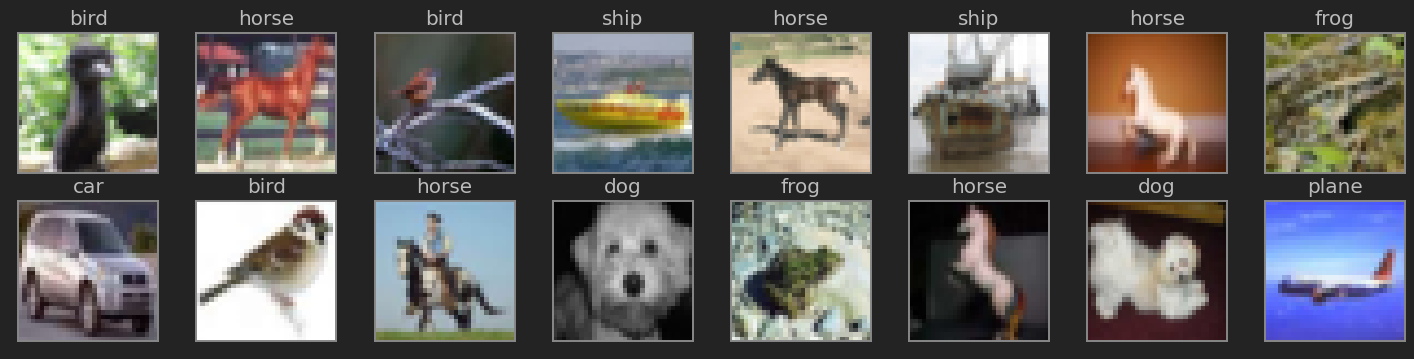

In [3]:
# Посмотрим, что внутри, добавим описание меток из оф. описания
labels_dict = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(18, 4))
cols, rows = 8, 2
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_dict[label])
    plt.xticks([]), plt.yticks([])
    plt.imshow(np.transpose(img, axes=(1, 2, 0)))
plt.show()

In [4]:
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=512,
                                           shuffle=True,
                                          )
valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                                          batch_size=512,
                                          shuffle=False, 
                                         )

---
## 1. Реализация структуры сети автоэнкодера на основе VGG11

In [5]:
transfer_model = models.vgg11(pretrained=True)
transfer_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [6]:
# зафиксируем все слои кроме 2х последних сверток с 512 фильтрами (тюнинг)
last_features = list(transfer_model.features.state_dict().keys())[-4:]
last_features

['16.weight', '16.bias', '18.weight', '18.bias']

In [7]:
for name, param in transfer_model.features.named_parameters():
    if np.isin(name, last_features):    
        param.requires_grad = True
    else:
        param.requires_grad = False

In [8]:
class Encoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Encoder, self).__init__()
        self.vgg11 = transfer_model.features
        self.hidden = self.hidden_block(hidden_dim)

    def hidden_block(self, hidden_dim):
        hidden_block = nn.Sequential(nn.Flatten(),
                                     nn.Linear(512*1*1, 128),
                                     nn.ReLU(),
                                     nn.Linear(128, hidden_dim))
        return hidden_block
        
    def forward(self, x):
        x = self.vgg11(x)
        x = self.hidden(x)
        
        return x
    
    
class Decoder(nn.Module):
    def __init__(self, hidden_dim):
        super(Decoder, self).__init__()
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 128, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.conv7 = nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1)
        self.upsmpl1 = nn.Upsample(size=2)
        self.upsmpl2 = nn.Upsample(size=4)
        self.upsmpl3 = nn.Upsample(size=8)
        self.upsmpl4 = nn.Upsample(size=16)
        self.upsmpl5 = nn.Upsample(size=32)
        self.fc = nn.Linear(128, 512*1*1)
        self.hidden = nn.Linear(hidden_dim, 128)
        self.unflat = nn.Unflatten(dim=1, unflattened_size=(512, 1, 1))
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.hidden(x)
        x = self.relu(x)
        x = self.fc(x)
        x = self.relu(x)
        x = self.unflat(x)
        
        x = self.upsmpl1(x) #  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        x = self.conv12(x) # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.relu(x)
        x = self.conv12(x) # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.relu(x)
        
        x = self.upsmpl2(x) # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        x = self.conv12(x) # Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.relu(x)
        x = self.conv3(x) # Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.relu(x)
        
        x = self.upsmpl3(x) # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        x = self.conv4(x) #  Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.relu(x)
        x = self.conv5(x) # Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.relu(x)
        
        x = self.upsmpl4(x) # MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        x = self.conv6(x) # Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.relu(x)
        
        x = self.upsmpl5(x) #  MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        x = self.conv7(x) # Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        x = self.sigmoid(x)
        
        return x

    
class AutoEncoder(nn.Module):
    def __init__(self, hidden_dim):
        super(AutoEncoder, self).__init__()
        self.enc = Encoder(hidden_dim)
        self.dec = Decoder(hidden_dim)
        
    def forward(self, x):
        x = self.enc(x)
        x = self.dec(x)
        
        return x

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = AutoEncoder(hidden_dim=8).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

---
## 2. Обучение автоэнкодера

In [10]:
def enc_model_run(model, data_loader, stage, device=torch.device('cpu'), clear_memory=True):
    '''
    Function of run the model with data loader generator
    '''
    loss_cum = 0
    for inputs, _ in data_loader:
        outputs = model(inputs.to(device))
        loss = criterion(outputs, inputs.to(device))
        loss_cum += loss.item()
        
        if stage=='train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if clear_memory:
            del inputs
            gc.collect()
            torch.cuda.empty_cache()
        
    return loss_cum

In [11]:
# Величина скрытого пространства
# HIDDEN_DIMENSION = 8

In [12]:
hidden_dimensions = [32, 16, 8, 4]

for HIDDEN_DIMENSION in hidden_dimensions:

    history = pd.DataFrame(columns=['hidden_dimension', 'epoch', 'train_loss', 'valid_loss'])

    # Инициализация модели
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    enc_model = AutoEncoder(hidden_dim=HIDDEN_DIMENSION).to(device)
    optimizer = torch.optim.Adam(enc_model.parameters(), lr=0.001)
    criterion = torch.nn.MSELoss()  

    # Запуск процесса обучения модели
    print(f'Start training with {HIDDEN_DIMENSION}-sized hidden dimension')
    for epoch in range(51):  
        for stage in ['train', 'eval']:
            # TRAIN
            if stage=='train':
                enc_model.train()
                loss_train = enc_model_run(enc_model, train_loader, stage, device)
            # EVALUATION
            elif stage=='eval':
                enc_model.eval()
                with torch.no_grad():
                    loss_valid = enc_model_run(enc_model, valid_loader, stage, device)

        history.loc[len(history)] = [HIDDEN_DIMENSION, epoch, loss_train / len(train_loader), loss_valid / len(valid_loader)]

        if (epoch % 10 == 0):
            print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}")

            
    torch.save(enc_model.to('cpu').state_dict(), f'./Models/VGGmodel_{HIDDEN_DIMENSION}-hidden_dim.pth')   
    history.to_csv(f'./History/VGGhistory_{HIDDEN_DIMENSION}-hidden_dim.csv')
    print(f'Training with {HIDDEN_DIMENSION}-sized hidden dimension is finished!')
    print('=' * 80)

Start training with 32-sized hidden dimension
Epoch: 0, train_loss: 0.0570740420371294, valid_loss: 0.04844604972749948
Epoch: 10, train_loss: 0.03360149937168676, valid_loss: 0.03387408833950758
Epoch: 20, train_loss: 0.02524250453071935, valid_loss: 0.028910249564796688
Epoch: 30, train_loss: 0.02323436467167066, valid_loss: 0.028381057549268007
Epoch: 40, train_loss: 0.021746842380689115, valid_loss: 0.027661650255322457
Epoch: 50, train_loss: 0.020423668493725816, valid_loss: 0.02739717336371541
Training with 32-sized hidden dimension is finished!
Start training with 16-sized hidden dimension
Epoch: 0, train_loss: 0.045635735996219576, valid_loss: 0.03928394578397274
Epoch: 10, train_loss: 0.021206570998290365, valid_loss: 0.026831851340830326
Epoch: 20, train_loss: 0.019615442263988817, valid_loss: 0.02718792287632823
Epoch: 30, train_loss: 0.018371686757523185, valid_loss: 0.02677917331457138
Epoch: 40, train_loss: 0.0173667686972387, valid_loss: 0.02721221502870321
Epoch: 50, tr

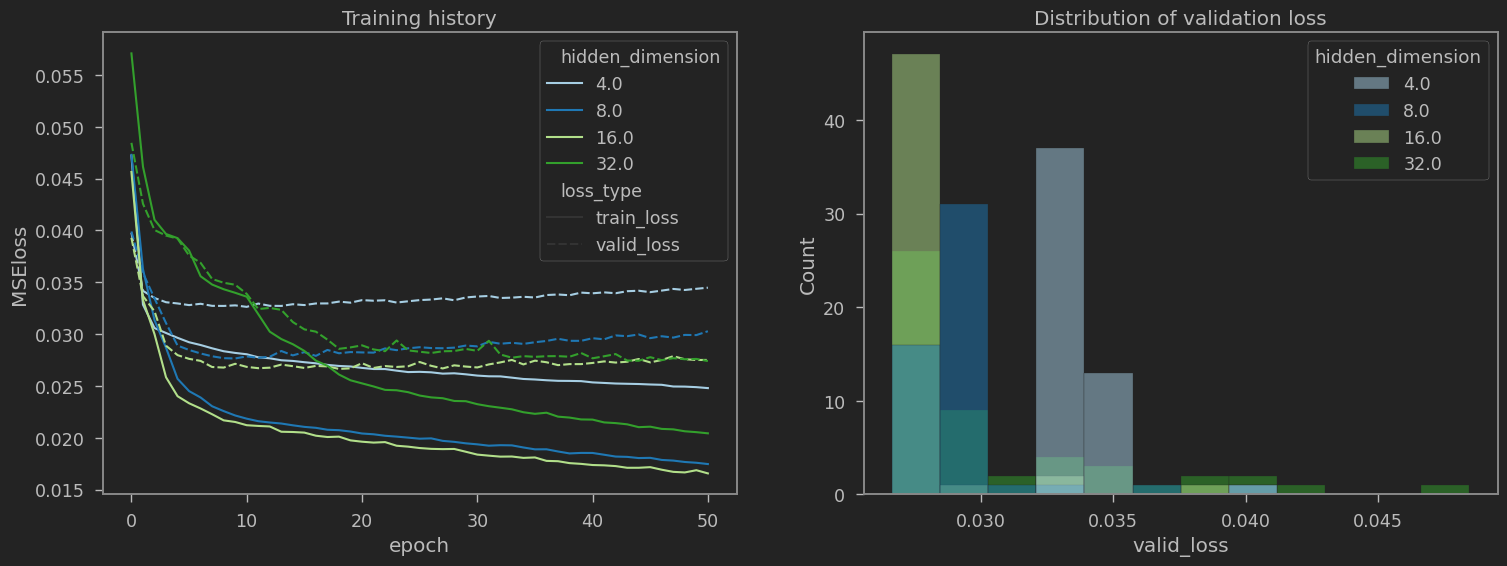

In [13]:
# Plot full history
history = pd.DataFrame()
for path in glob.glob('./History/VGGhistory_*.csv'):
    history = pd.concat([history, pd.read_csv(path, index_col=0, dtype={'train_loss': 'float64', 'valid_loss': 'float64'})], axis=0)
    
plt.figure(figsize=(18, 6))
plt.subplot(121)
sns.lineplot(data=history.melt(id_vars=['hidden_dimension', 'epoch'], 
                               value_vars=['train_loss', 'valid_loss'], 
                               var_name='loss_type',
                               value_name='MSEloss'),
             x='epoch', 
             y='MSEloss',
             hue='hidden_dimension', 
             style='loss_type',
             palette='Paired',
            )
plt.title('Training history')

plt.subplot(122)
sns.histplot(data=history, x='valid_loss', hue='hidden_dimension', palette='Paired')
plt.title('Distribution of validation loss')
plt.show()

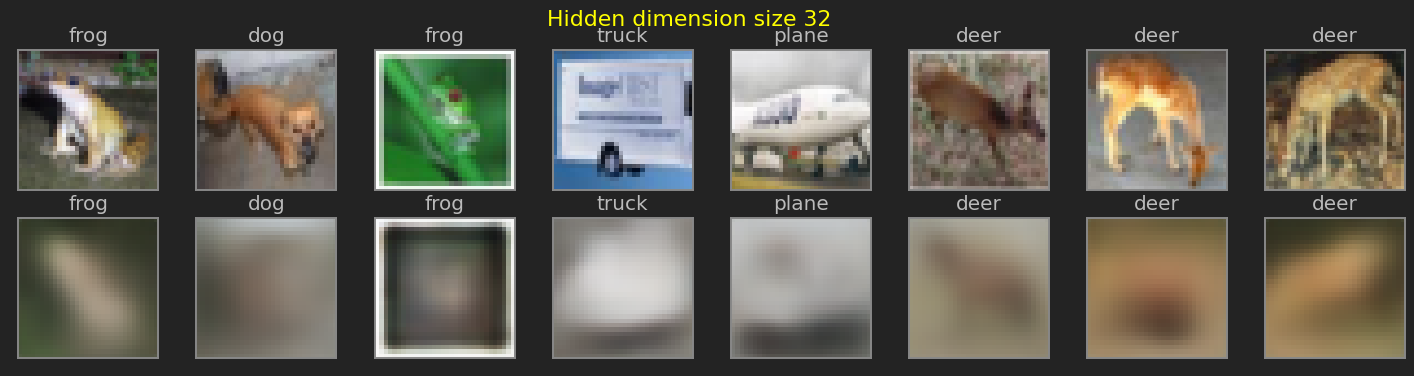

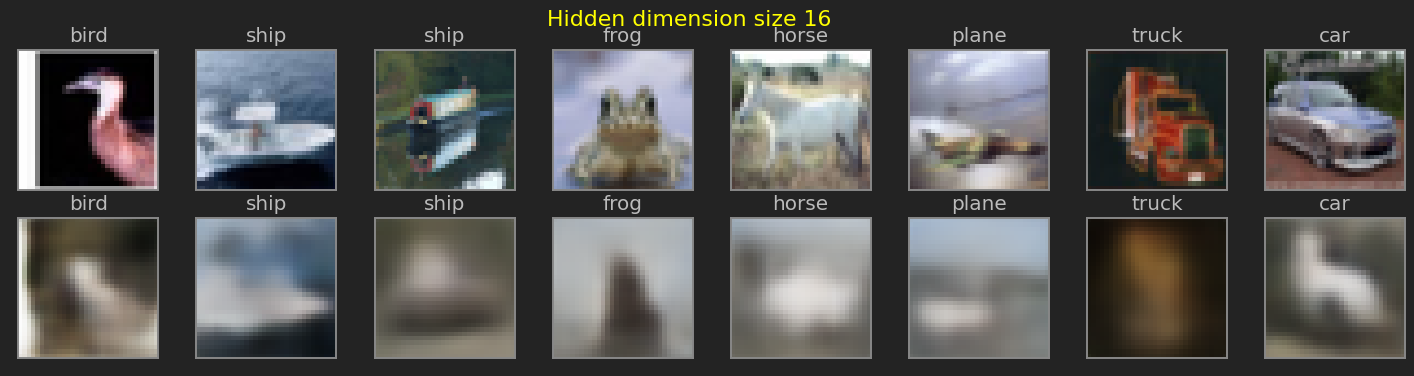

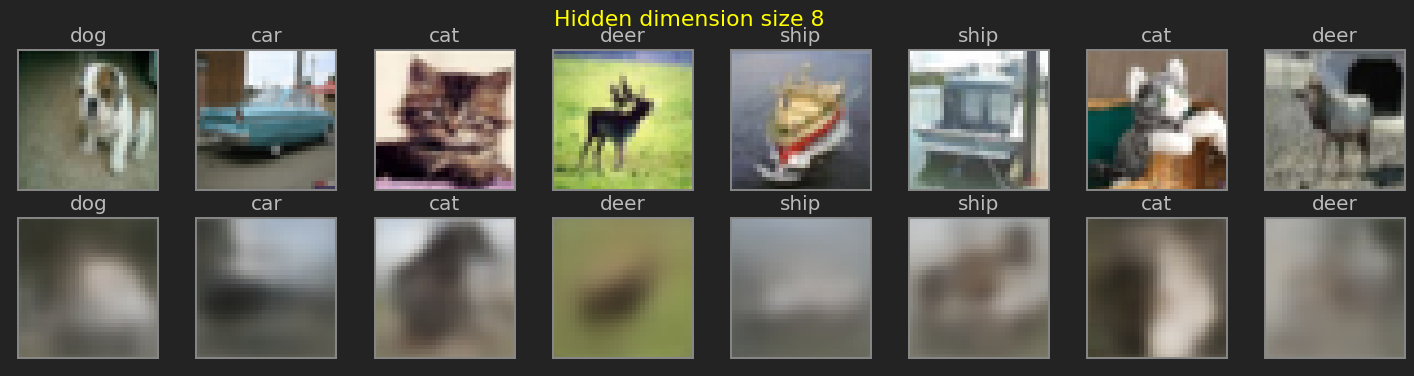

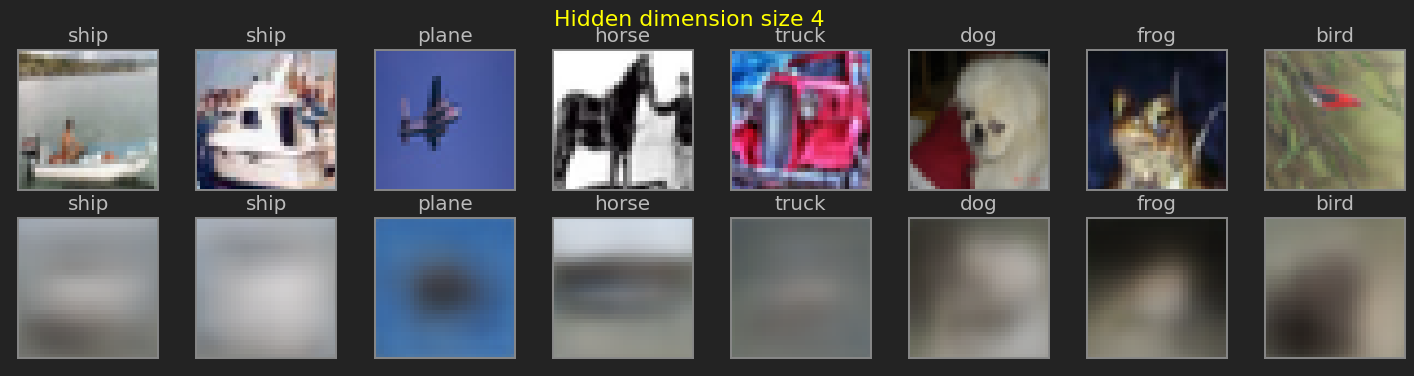

In [14]:
device = torch.device('cpu')
for HIDDEN_DIMENSION in hidden_dimensions:
    model = AutoEncoder(hidden_dim=HIDDEN_DIMENSION)
    model.load_state_dict(torch.load(f'./Models/VGGmodel_{HIDDEN_DIMENSION}-hidden_dim.pth', map_location=device))

    figure = plt.figure(figsize=(18, 4))
    cols, rows = 8, 2
    for i in range(1, cols + 1):
        sample_idx = torch.randint(len(valid_dataset), size=(1,)).item()
        img, label = valid_dataset[sample_idx]
        prediction = model(img[None, :, :, :]).detach().numpy()[0]
        prediction[prediction > 1.] = 1.
        
        figure.add_subplot(rows, cols, i)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(img, axes=(1, 2, 0)))

        figure.add_subplot(rows, cols, i+8)
        plt.title(labels_dict[label])
        plt.xticks([]), plt.yticks([])
        plt.imshow(np.transpose(prediction, axes=(1, 2, 0)))
    
    plt.suptitle(f'Hidden dimension size {HIDDEN_DIMENSION}', color='yellow')
    plt.show()

In [15]:
def draw_embeddings(X_embedded, targets, labels):
    plt.figure(figsize=(8, 6))
    for class_idx in range(np.max(targets) + 1):
        X_embedded_class = X_embedded[targets == class_idx, :]
        plt.scatter(X_embedded_class[:, 0], X_embedded_class[:, 1])
    plt.legend(labels, bbox_to_anchor=(1.01, 1.0))
    plt.grid(True)

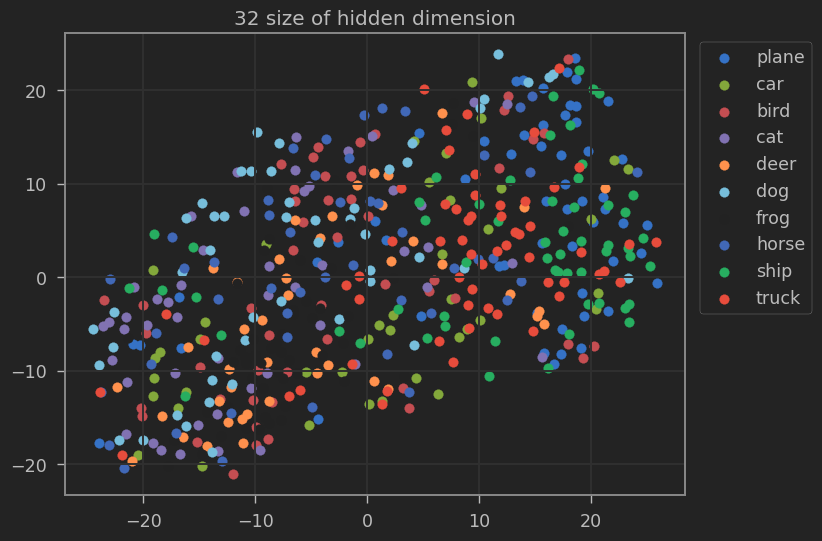

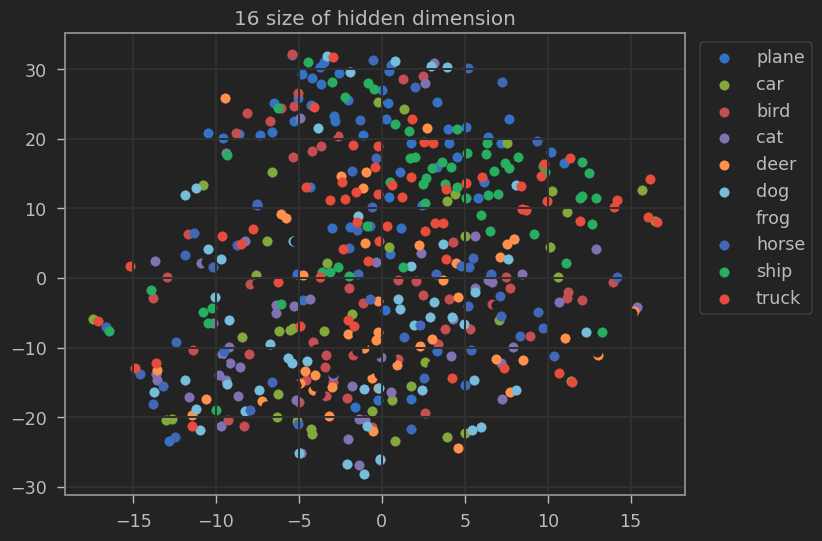

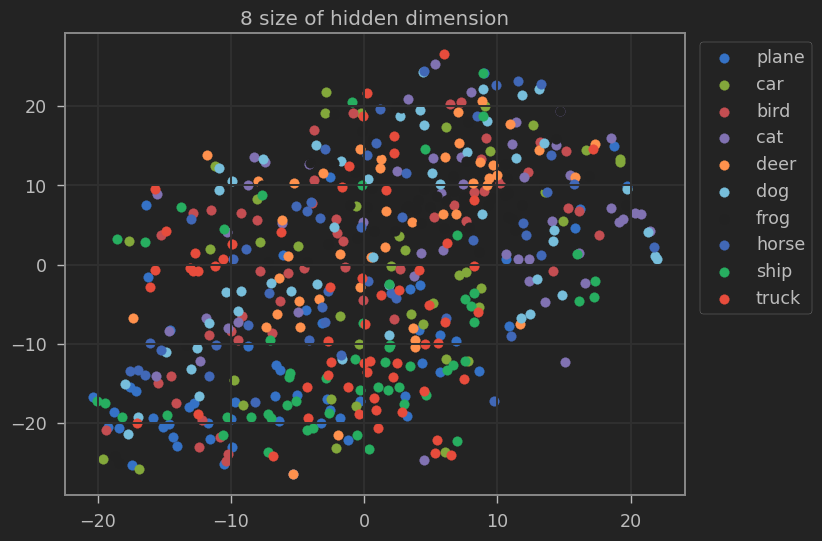

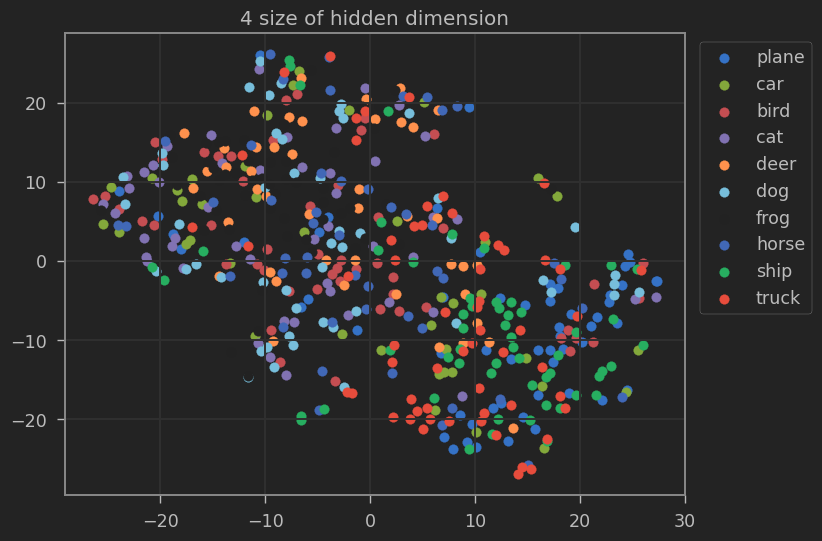

In [17]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

for HIDDEN_DIMENSION in hidden_dimensions:
    model = AutoEncoder(hidden_dim=HIDDEN_DIMENSION)
    model.load_state_dict(torch.load(f'./Models/VGGmodel_{HIDDEN_DIMENSION}-hidden_dim.pth', map_location=device))
    pretrained_encoder = model.enc
    test_embs = pretrained_encoder(x).detach().numpy()
    test_embs_2D = TSNE(n_components=2).fit_transform(test_embs)
    draw_embeddings(test_embs_2D, y.detach().numpy(), labels_dict.values())
    plt.title(f'{HIDDEN_DIMENSION} size of hidden dimension')

### Анализ автоэнкодера
Автоэнкодеры сработали не очень хорошо. Они воспроизводят оттенки и цвета, но не сам объект. Какого-либо четкого разделения на XY-графиках также не наблюдатеся. Судя по loss-функции и визуализации латентные пространства 16 и 32 имеют схожее качество. Для классификатора попробуем взять 16-мерное скрытое пространство.

---
## 3. Реализация модели-классификатора

In [18]:
HIDDEN_DIMENSION = 16

In [19]:
model = AutoEncoder(hidden_dim=HIDDEN_DIMENSION)
model.load_state_dict(torch.load(f'./Models/VGGmodel_{HIDDEN_DIMENSION}-hidden_dim.pth', map_location=device))

# Отрежем энкодер от модели автоэнкодера и зафиксируем его параметры
pretrained_encoder = model.enc
for param in pretrained_encoder.parameters():
    param.requires_grad = False
pretrained_encoder

Encoder(
  (vgg11): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [20]:
class ClassificationModel(nn.Module):
    def __init__(self, input_dim):
        super(ClassificationModel, self).__init__()
        self.enc = pretrained_encoder

        self.fc_1st = nn.Linear(input_dim, 1024)
        self.fc_2nd = nn.Linear(1024, 1024)
        self.fc_3rd = nn.Linear(1024, 10)

    def forward(self, x):
        x = self.enc(x)

        x = self.fc_1st(x)
        x = F.relu(x)
        
        x = self.fc_2nd(x)
        x = F.relu(x)
        
        x = self.fc_3rd(x)
        
        return x

In [21]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
clas_model = ClassificationModel(input_dim=HIDDEN_DIMENSION).to(device)
summary(clas_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
              ReLU-2           [-1, 64, 32, 32]               0
         MaxPool2d-3           [-1, 64, 16, 16]               0
            Conv2d-4          [-1, 128, 16, 16]          73,856
              ReLU-5          [-1, 128, 16, 16]               0
         MaxPool2d-6            [-1, 128, 8, 8]               0
            Conv2d-7            [-1, 256, 8, 8]         295,168
              ReLU-8            [-1, 256, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         590,080
             ReLU-10            [-1, 256, 8, 8]               0
        MaxPool2d-11            [-1, 256, 4, 4]               0
           Conv2d-12            [-1, 512, 4, 4]       1,180,160
             ReLU-13            [-1, 512, 4, 4]               0
           Conv2d-14            [-1, 51

---
## 4.  Обучение модели-классификатора

In [22]:
optimizer = torch.optim.Adam(clas_model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [23]:
def clas_model_run(model, data_loader, stage, device=torch.device('cpu'), clear_memory=True):
    '''
    Function of run the model with data loader generator
    '''
    loss_cum = 0
    accuracy = 0.
    total = 0.
    for inputs, labels in data_loader:
        outputs = model(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss_cum += loss.item()
        
        if stage=='train':
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        elif stage=='eval':
            y_pred_softmax = torch.log_softmax(model(inputs.to(device)), dim=1)
            _, predicted = torch.max(y_pred_softmax.data, dim=1)
            total += labels.size(0)
            accuracy += (predicted==labels.to(device)).sum().item()
        
        if clear_memory:
            del inputs, labels
            gc.collect()
            torch.cuda.empty_cache()
        
    return loss_cum if stage=='train' else (loss_cum, (100 * accuracy / total))

In [25]:
for epoch in range(31):  
    for stage in ['train', 'eval']:
        # TRAIN
        if stage=='train':
            clas_model.train()
            loss_train = clas_model_run(clas_model, train_loader, stage, device)
        # EVALUATION
        elif stage=='eval':
            clas_model.eval()
            with torch.no_grad():
                loss_valid, accuracy = clas_model_run(clas_model, valid_loader, stage, device)

    if (epoch % 10 == 0):
        print(f"Epoch: {epoch}, train_loss: {loss_train / len(train_loader)}, valid_loss: {loss_valid / len(valid_loader)}, valid Accuracy: {accuracy}%")

clas_model = clas_model.to('cpu')
torch.save(clas_model.state_dict(), './Models/VGGclassification_model.pth')   
print(f'Training is finished!')

Epoch: 0, train_loss: 1.6895797690566705, valid_loss: 1.5567786276340485, valid Accuracy: 44.04%
Epoch: 10, train_loss: 1.2940352960508696, valid_loss: 1.4525052845478057, valid Accuracy: 48.23%
Epoch: 20, train_loss: 1.0875763461297872, valid_loss: 1.5114493250846863, valid Accuracy: 48.15%
Epoch: 30, train_loss: 0.8567661046981812, valid_loss: 1.6834334969520568, valid Accuracy: 46.37%
Training is finished!


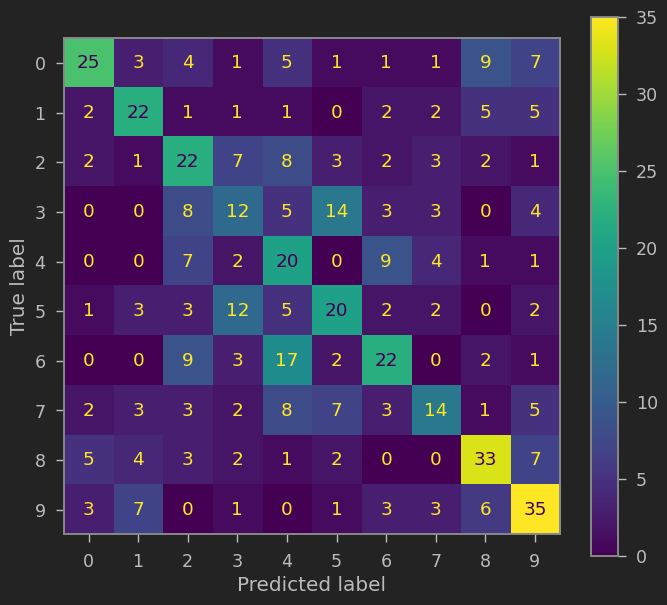

In [26]:
dataloader_iterator = iter(valid_loader)
x, y = next(dataloader_iterator)

_, predicted = torch.max(clas_model(x).data, 1)
cm = confusion_matrix(y, predicted)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot( values_format ='.3g')
plt.show()

---
## 5. Выводы и идеи
Классификатор с энкодером VGG11 показал себя существенно лучше, чем небольшая сетка, собранная в ручную. Была также попытка училичить размер feature-блока, взяв VGG16, однако это на качество результата не повлияло. Вероятно, для улучшения качества сети нужно попробовать использовать более масштабные латентные пространства.